In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

%matplotlib inline

from model import BestFitModel, Predict, Model, Prediction

sns.set_theme()
MAX_OFFSET = 45

In [6]:
# load and filter the dataset to just the locale and period of interest
raw_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', usecols=['date', 'iso_code', 'new_deaths', 'new_cases', 'new_deaths_smoothed', 'new_cases_smoothed'], parse_dates=['date'])
df = raw_data[(raw_data.iso_code == 'USA') & (raw_data.date >= np.datetime64('2020-06-24')) &
    (~raw_data.new_deaths.isnull()) &
    (~raw_data.new_cases.isnull()) &
    (~raw_data.new_deaths_smoothed.isnull()) &
    (~raw_data.new_cases_smoothed.isnull())]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 52302 to 52480
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   iso_code             179 non-null    object        
 1   date                 179 non-null    datetime64[ns]
 2   new_cases            179 non-null    float64       
 3   new_cases_smoothed   179 non-null    float64       
 4   new_deaths           179 non-null    float64       
 5   new_deaths_smoothed  179 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 9.8+ KB


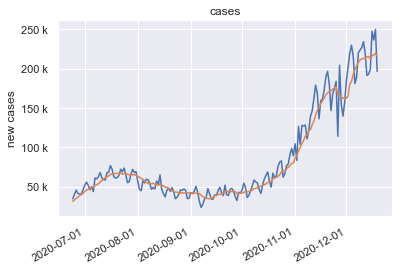

In [7]:
fig, ax = plt.subplots()
plt.title("cases") 

ax.set_ylabel("new cases") 
ax.plot(df["date"], df[['new_cases']])
ax.plot(df["date"], df[['new_cases_smoothed']])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
fig.autofmt_xdate()

plt.show()

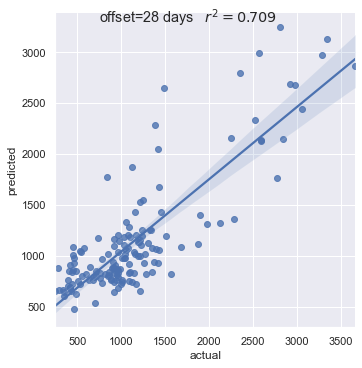

In [8]:
model = BestFitModel(df[['new_cases']], df['new_deaths'], MAX_OFFSET)

fig = sns.lmplot(data= pd.DataFrame({'predicted': model.predictions, 'actual': model.actuals}), x="actual", y="predicted").fig
fig.suptitle(rf"offset={model.offset} days   $r^2={round(model.r2,3)}$")

fig.savefig("daily.png")

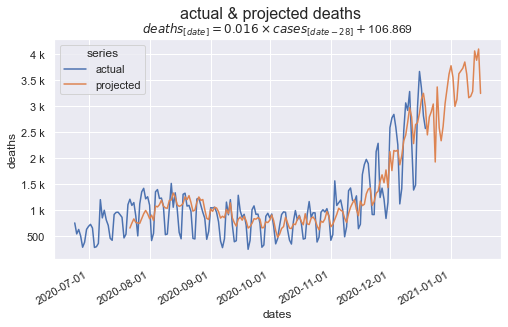

In [5]:
prediction = Predict(model, df["date"], df[['new_cases']], df['new_deaths'])

frame = pd.DataFrame({"dates": prediction.dates, 
    "actual": prediction.actuals, 
    "projected": prediction.predictions})

data = frame.melt(id_vars=['dates'], var_name='series', value_name='deaths')

ax = sns.lineplot(data=data, x="dates", y="deaths", hue="series")
ax.set_title(fr'$deaths_{{[date]}}={round(model.linearModel.coef_[0], 3)} \times cases_{{[date-{model.offset}]}} + ${round(model.linearModel.intercept_, 3)}', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())

fig = ax.figure
fig.set_size_inches(8, 4.5)
fig.suptitle('actual & projected deaths', fontsize=16)
fig.autofmt_xdate()

fig.savefig("dailycomparison.png")

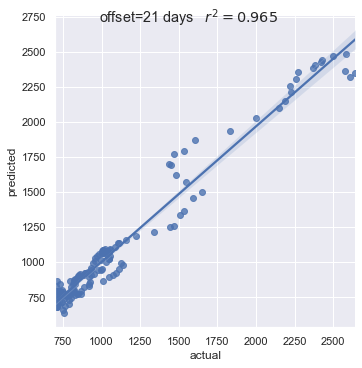

In [6]:
model = BestFitModel(df[['new_cases_smoothed']], df['new_deaths_smoothed'], MAX_OFFSET)

fig = sns.lmplot(data= pd.DataFrame({'predicted': model.predictions, 'actual': model.actuals}), x="actual", y="predicted").fig
fig.suptitle(rf"offset={model.offset} days   $r^2={round(model.r2,3)}$")

fig.savefig("smoothed.png")

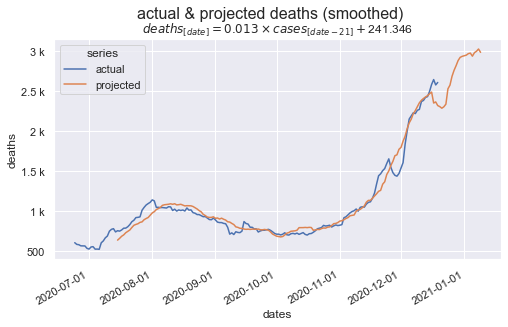

In [7]:
prediction = Predict(model, df["date"], df[['new_cases_smoothed']], df['new_deaths_smoothed'])

frame = pd.DataFrame({"dates": prediction.dates, 
    "actual": prediction.actuals, 
    "projected": prediction.predictions})

data = frame.melt(id_vars=['dates'], var_name='series', value_name='deaths')

ax = sns.lineplot(data=data, x="dates", y="deaths", hue="series")
ax.set_title(fr'$deaths_{{[date]}}={round(model.linearModel.coef_[0], 3)} \times cases_{{[date-{model.offset}]}} + ${round(model.linearModel.intercept_, 3)}', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())

fig = ax.figure
fig.set_size_inches(8, 4.5)
fig.suptitle('actual & projected deaths (smoothed)', fontsize=16)
fig.autofmt_xdate()

fig.savefig("smoothedcomparison.png")